Import libraries and setup plot

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from solver import Solver

Create a solver for size (20, 20)

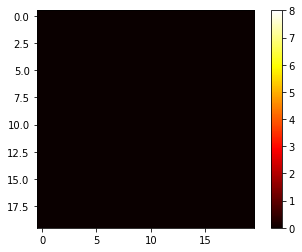

In [2]:
solver = Solver(width=20, height=20)
solver.plot()

Create a tower

In [3]:
tower = solver.create_random_tower()

Add the tower to the solver

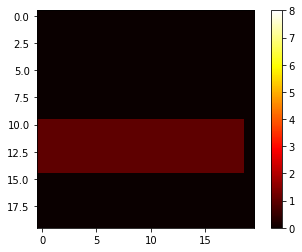

In [4]:
solver.add_tower(tower)
solver.plot()